In [1]:
#In the initial submission, some columns of the dataset were dropped, for simplicity's sake
#This time, we will be revising the Titanic datasat in order to try to extract as much information as possible
# in order to improve the sumission score.

In [2]:
import pandas as pd
import zipfile

In [3]:
zf=zipfile.ZipFile(r'C:\Users\Hov\Desktop\kaggle_titanic/titanic.zip')
df_train = pd.read_csv(zf.open('train.csv'))

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# One of the columns that we dropped was "Name".
# At a first glance, it seems that names are stored as <last name> <comma> <title> < first name>
# Knowing that families were travelling on the Titanic, it might be useful to know how many members a family had onboard 
# (assumming that people with the same last name were related)

In [6]:
# In order to hame the complete picture, we will be using both the train and the test set to count family members
# for each last name, as some members of the same family might be in the test set.
# We won't be using the test set to train the model on it.

In [7]:
# Let's read the test set
df_test = pd.read_csv(zf.open('test.csv'))

In [8]:
# Now for putting together the two dataframes
frames = [df_train,df_test]
df= pd.concat(frames, sort= False)

In [9]:
# Extracting the last name from each cell of the column and saving it in a column named "fam_name"
df["fam_name"] =  df["Name"].str.split(',').str[0].str.strip()

In [10]:
# Let's see the number of family members for each name
df["fam_name"].value_counts()

Sage         11
Andersson    11
Goodwin       8
Asplund       8
Davies        7
             ..
Turja         1
Keefe         1
Harmer        1
Cohen         1
Wilson        1
Name: fam_name, Length: 875, dtype: int64

In [11]:
#Let's save the number of members for each last name
df_family_members = df["fam_name"].value_counts().rename_axis('fam_name').reset_index(name="members")

In [12]:
# And now to add the number of family members for each passenger according to their name, 
# in another column of the train dataframe
df_train["fam_name"] =  df_train["Name"].str.split(',').str[0].str.strip()
df_train = pd.merge(df_train, df_family_members, on='fam_name', how='left')

In [13]:
# Another feature that might be useful, is title
# Let's extract this feature and see how it looks
title = df_train["Name"].str.split(',').str[1].str.strip().str.split('.').str[0].str.strip()

In [14]:
# The values that it might take
title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [15]:
# And number of occurances in the train dataset
title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Lady              1
Jonkheer          1
Mme               1
Don               1
Sir               1
Ms                1
the Countess      1
Capt              1
Name: Name, dtype: int64

In [16]:
# For simplicity we will be using the first 4, creating a column for each of them as they are the most numerous
df_train["is_mr"]= df_train["Name"].str.contains('Mr.', regex=False)
df_train["is_master"]= df_train["Name"].str.contains('Master.', regex = False)
df_train["is_miss"]= df_train["Name"].str.contains('Miss', regex = False)
df_train["is_mrs"]= df_train["Name"].str.contains('Mrs.',regex=False)

In [17]:
# In the first submission, we imputed the missing values of age with the mean of the entire dataset
# Since titles might be indicative of age, let's use them for a more precise imputation
mr_age = df_train.query('is_mr == True').Age.mean()
master_age = df_train.query('is_master == True').Age.mean()
miss_age = df_train.query('is_miss == True').Age.mean()
mrs_age = df_train.query('is_mrs == True').Age.mean()

In [18]:
# Replacing the missing value of age with the appropiate mean, according to passanger title
df_train.loc[(df_train["Age"].isna() == True) & (df_train.is_mr == True), "Age"]=mr_age
df_train.loc[(df_train["Age"].isna() == True) & (df_train.is_master == True), "Age"]=master_age
df_train.loc[(df_train["Age"].isna() == True) & (df_train.is_miss == True), "Age"]= miss_age
df_train.loc[(df_train["Age"].isna() == True) & (df_train.is_mrs == True), "Age"]=mrs_age
df_train.loc[(df_train["Age"].isna() == True),"Age"] = mr_age

In [19]:
# Another column that might store some useful information is "Ticket"
df_train["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [20]:
# Some seem to be completely numeric, while others have also some characters in their name
# Let's first identify the ones that are made up of just numbers and store this information in another column
df_train["ticket_is_num"] = df_train["Ticket"].str.isdigit()

In [21]:
# Let's take a look at the other tickets and their non-numeric part; we will be splitting by space 
# and count each individual value
df_train.query('ticket_is_num==False').Ticket.str.split(' ').str[0].str.strip().value_counts()

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
SOTON/OQ       7
A/5.           7
STON/O2.       6
CA             6
C              5
S.O.C.         5
SC/PARIS       5
F.C.C.         5
SC/Paris       4
LINE           4
A/4            3
S.O./P.P.      3
SC/AH          3
PP             3
A/4.           3
A./5.          2
A.5.           2
S.C./PARIS     2
P/PP           2
SOTON/O2       2
WE/P           2
W.E.P.         1
F.C.           1
Fa             1
W/C            1
SCO/W          1
S.W./PP        1
C.A./SOTON     1
SC             1
S.P.           1
A4.            1
A/S            1
S.C./A.4.      1
S.O.P.         1
SO/C           1
SW/PP          1
Name: Ticket, dtype: int64

In [22]:
# We will add another column to the train dataframe and initially fill it with the value "other"
df_train["ticket_segment"] = "other"

In [23]:
#Create a column to store the ticket type
df_train["ticket_type"] = df_train.query('ticket_is_num==False').Ticket.str.split(' ').str[0].str.strip()

In [24]:
# Now, according to the value of the ticket we will fill-in the "ticket_segment" 
df_train.loc[df_train["ticket_is_num"] == True, "ticket_segment"] = "num"
df_train.loc[df_train["ticket_type"] == "PC", "ticket_segment"] = "PC"
df_train.loc[df_train["ticket_type"].isin(["C.A.","CA.","CA"]), "ticket_segment"] = "CA"
df_train.loc[df_train["ticket_type"].isin(["A/5","A/5.","A./5.","A.5.","A/4","A/4."]), "ticket_segment"] = "A"
df_train.loc[df_train["ticket_type"].isin(["STON/O","SOTON/O.Q.","SOTON/OQ","STON/O2."]), "ticket_segment"] = "STON"
df_train.loc[df_train["ticket_type"].isin(["SC/PARIS","SC/Paris","SC/AH","S.C./PARIS"]), "ticket_segment"] = "SC"

In [25]:
# Let's take a look at the dataframe
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,fam_name,members,is_mr,is_master,is_miss,is_mrs,ticket_is_num,ticket_segment,ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Braund,2,True,False,False,False,False,A,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,Cumings,2,False,False,False,True,False,PC,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Heikkinen,1,False,False,True,False,False,STON,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,Futrelle,2,False,False,False,True,True,num,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,Allen,2,True,False,False,False,True,num,NaN


In [26]:
# Now to keep only columns and rows we will be using for modeling
df_train.drop(columns=['PassengerId', 'Name','Ticket','Cabin','fam_name','ticket_is_num','ticket_type'],inplace=True)
df_train.dropna(subset=['Embarked'], inplace=True)

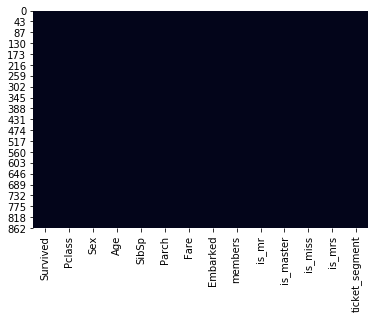

In [27]:
# Let's check for any missing values
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(df_train.isnull(),cbar=False)

In [28]:
# Imports for creating a datapipe for transforming the variables
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [29]:
column_trans = make_column_transformer((OneHotEncoder(),['Sex','Embarked','ticket_segment']),
                                       (StandardScaler(),['Age','Fare'])
                                       ,remainder='passthrough')

In [30]:
# Let's separate the target variable from the independent variables
X = df_train.drop(['Survived'], axis = 1)
y_train = df_train['Survived']

In [31]:
# Apply the transformations to the independent variables
X_train =  column_trans.fit_transform(X)

In [32]:
#Importing the  logstic regression, decision tree and boosting models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestRegressor
#Import cross validation metric for testing the accuracy of the models
from sklearn.model_selection import cross_val_score

In [33]:
#creat models
logreg = LogisticRegression(solver='lbfgs')
xgbmod=xgb.XGBClassifier(random_state=5,learning_rate=0.01)
treemod = dtc(max_depth=10)

In [34]:
#evaluate models
print(
cross_val_score(logreg,X_train,y_train,cv=5,scoring='accuracy').mean(),
    '\n',
cross_val_score(xgbmod,X_train,y_train,cv=5,scoring='accuracy').mean(),
    '\n',
cross_val_score(treemod,X_train,y_train,cv=5,scoring='accuracy').mean()

)

0.831314670221545 
 0.8312956262299245 
 0.7975242810893164


In [35]:
# Apply the same transformations to it 

In [36]:
df_test["fam_name"] =  df_test["Name"].str.split(',').str[0].str.strip()

In [37]:
df_test = pd.merge(df_test, df_family_members, on='fam_name', how='left')

In [38]:
df_test["is_mr"]= df_test["Name"].str.contains('Mr.', regex=False)
df_test["is_master"]= df_test["Name"].str.contains('Master.', regex = False)
df_test["is_miss"]= df_test["Name"].str.contains('Miss', regex = False)
df_test["is_mrs"]= df_test["Name"].str.contains('Mrs.',regex=False)

In [39]:
mr_age = df_test.query('is_mr == True').Age.mean()
master_age = df_test.query('is_master == True').Age.mean()
miss_age = df_test.query('is_miss == True').Age.mean()
mrs_age = df_test.query('is_mrs == True').Age.mean()

In [40]:
df_test.loc[(df_test["Age"].isna() == True) & (df_test.is_mr == True), "Age"]=mr_age
df_test.loc[(df_test["Age"].isna() == True) & (df_test.is_master == True), "Age"]=master_age
df_test.loc[(df_test["Age"].isna() == True) & (df_test.is_miss == True), "Age"]= miss_age
df_test.loc[(df_test["Age"].isna() == True) & (df_test.is_mrs == True), "Age"]=mrs_age
df_test.loc[(df_test["Age"].isna() == True),"Age"] = mr_age

In [41]:
df_test["ticket_is_num"] = df_test["Ticket"].str.isdigit()

In [42]:
df_test["ticket_type"] = df_test.query('ticket_is_num==False').Ticket.str.split(' ').str[0].str.strip()

In [43]:
df_test["ticket_segment"] = "other"

In [44]:
df_test.loc[df_test["ticket_is_num"] == True, "ticket_segment"] = "num"
df_test.loc[df_test["ticket_type"] == "PC", "ticket_segment"] = "PC"
df_test.loc[df_test["ticket_type"].isin(["C.A.","CA.","CA"]), "ticket_segment"] = "CA"
df_test.loc[df_test["ticket_type"].isin(["A/5","A/5.","A./5.","A.5.","A/4","A/4."]), "ticket_segment"] = "A"
df_test.loc[df_test["ticket_type"].isin(["STON/O","SOTON/O.Q.","SOTON/OQ","STON/O2."]), "ticket_segment"] = "STON"
df_test.loc[df_test["ticket_type"].isin(["SC/PARIS","SC/Paris","SC/AH","S.C./PARIS"]), "ticket_segment"] = "SC"

In [45]:
df_test.drop(columns=['PassengerId', 'Name','Ticket','Cabin','fam_name','ticket_is_num','ticket_type'],inplace=True)

In [46]:
# Imputing the missing value of "Fare" with the mean
df_test.loc[(df_test["Fare"].isna() == True),"Fare"] = df_test["Fare"].mean()

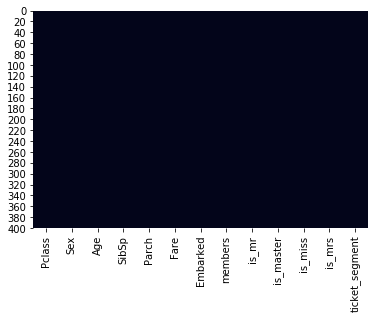

In [47]:
#One last look to check for missing values
sns.heatmap(df_test.isnull(),cbar=False)

In [48]:
# Apply the transformations
X_test = column_trans.fit_transform(df_test)

In [49]:
#train the logistic model, apply it to the new cases and export predictions in a csv file for submission
logmod = logreg.fit(X_train,y_train)
log_pred = logmod.predict(X_test)
pd.DataFrame(log_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\log_pred_fe.csv")

In [50]:
#same for the boosting model
xgbmod.fit(X_train, y_train)
xgb_pred = xgbmod.predict(X_test)
pd.DataFrame(xgb_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\xgb_pred_fe.csv")

In [51]:
#and the decision tree model
tree = treemod.fit(X_train,y_train)
tree_pred = tree.predict(X_test)
pd.DataFrame(tree_pred).to_csv(r"C:\Users\Hov\Desktop\kaggle_titanic\tree_pred_fe.csv")

In [52]:
# The logistic model registered the highest score of 0.78947